**Last Updated**: *25 April 2025*

**Part I: Detection of Local Minima**
   - Identify local minima based on a rescaled DEM & slope map (5m resolution).

In [1]:
# === Modules ===
import numpy as np
from osgeo import gdal
from numpy.lib.stride_tricks import as_strided
import time
import csv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage.segmentation import flood
from skimage.feature import canny
from skimage.measure import regionprops, label
from scipy.ndimage import distance_transform_edt, binary_erosion
from tqdm import tqdm

In [2]:
# === Functions ===
def load_data(file_path):
    """
    Input: DEM (raster) file path 
    Output: DEM (array) and geotransform information
    """
    try:
        gdal.UseExceptions()
        data = gdal.Open(file_path)
        if data is None:
            raise FileNotFoundError(f"Could not open file: {file_path}")
        data_array = data.ReadAsArray()
        geotransform = data.GetGeoTransform()
        return data_array, geotransform
    except Exception as e:
        raise RuntimeError(f"Error loading DEM: {e}")

def normalize_data(data):
    """
    Input: DEM (array)
    Output: Normalized DEM (array)
    """
    return (data - np.min(data)) / (np.max(data) - np.min(data))    # 0-1 range


def detect_local_minima(dem_norm, slope_norm, elevation_range, slope_range, window_size=5):
    """
    Input: Normalized DEM & slope (array), ranges, window size
    Output: Local minima mask
    """
    rows, cols = dem_norm.shape
    shape = (rows - window_size + 1, cols - window_size + 1, window_size, window_size)
    strides = (dem_norm.strides[0], dem_norm.strides[1],
               dem_norm.strides[0], dem_norm.strides[1])

    dem_sliding_windows = as_strided(dem_norm, shape, strides)
    local_minima = np.percentile(dem_sliding_windows, 40, axis=(2, 3)) 
    depth = np.ptp(dem_sliding_windows, axis=(2, 3))

    center_values = dem_norm[window_size // 2:rows - window_size // 2,
                             window_size // 2:cols - window_size // 2]

    slope_sliding_windows = as_strided(slope_norm, shape, strides)
    steepest_slope = np.max(slope_sliding_windows, axis=(2, 3))
    
    mask = (center_values <= local_minima) & ((depth >= 1.0/elevation_range) | (steepest_slope <= 20/slope_range))
    
    labeled_mask = label(mask, connectivity = 1)
    central_mask = np.zeros_like(labeled_mask, dtype=bool)

    for region in tqdm(regionprops(labeled_mask), desc="Processing blobs"):
        area = region.area
        coords = region.coords
        minr, minc, maxr, maxc = region.bbox
        
        submask = np.zeros((maxr - minr, maxc - minc), dtype=bool)
        submask[coords[:, 0] - minr, coords[:, 1] - minc] = True

        if area == 1:
            continue
        
        if area > 30:
            eroded = binary_erosion(submask, structure=np.ones((3, 3)))
            if np.any(eroded):
                submask = eroded

        cleaned_coords = np.argwhere(submask)
        if cleaned_coords.size == 0:
            continue
        
        centroid = np.mean(cleaned_coords, axis=0)
        full_pos = (int(round(centroid[0] + minr)), int(round(centroid[1] + minc)))

        if (0 <= full_pos[0] < central_mask.shape[0]) and (0 <= full_pos[1] < central_mask.shape[1]):
            central_mask[full_pos] = True

    return central_mask

def extract_coordinates(mask, geotransform, window_size):
    """
    Input: Local minima (mask), geotransform information and focal window size
    Output: Local minima (coordinates)
    """
    coordinates = []
    for i, j in zip(*np.nonzero(mask)):
        center_x = window_size // 2 + j
        center_y = window_size // 2 + i
        geo_x = geotransform[0] + center_x * geotransform[1] + center_y * geotransform[2]
        geo_y = geotransform[3] + center_x * geotransform[4] + center_y * geotransform[5]
        coordinates.append((len(coordinates) + 1, geo_x, geo_y))
    return coordinates

def save_to_csv(data, filename, headers):
    """
    Input: Local minima (coordinates), filename and headers
    Output: Local minima (CSV)
    """
    try:
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(headers)
            writer.writerows(data)
        print(f"Results saved to {filename}")
    except Exception as e:
        raise RuntimeError(f"Error writing to CSV: {e}")

In [3]:
# === Detect local minima with tiling ===
dem_path = "Data/tifs/train_DHMVIIDTMRAS1m_k32_rescaled_5m.tif"
slope_path = "Data/tifs/train_slope1m_k32_rescaled_5m.tif"
output_csv = "Data/train_local_minima.csv"

window_size = 9

try:
    dem_array, geotransform = load_data(dem_path)
    slope_array, _ = load_data(slope_path)

    chunk_size = dem_array.shape[0] // 2
    margin = window_size // 2
    results = []

    nrows, ncols = dem_array.shape

    n_chunks_rows = (nrows + chunk_size - 1) // chunk_size  
    n_chunks_cols = (ncols + chunk_size - 1) // chunk_size

    print(f"Chunks to process: {n_chunks_rows * n_chunks_cols}")
    
    start_time = time.time()
    
    for i in range(0, nrows, chunk_size):
        for j in range(0, ncols, chunk_size):
            # Compute bounds
            i_start = max(i - margin, 0)
            i_end = min(i + chunk_size + margin, nrows)
            j_start = max(j - margin, 0)
            j_end = min(j + chunk_size + margin, ncols)

            # Slicing
            dem_chunk = dem_array[i_start:i_end, j_start:j_end]
            slope_chunk = slope_array[i_start:i_end, j_start:j_end]

            # Normalize per chunk
            dem_norm_chunk = normalize_data(dem_chunk)
            slope_norm_chunk = normalize_data(slope_chunk)
            elevation_range = np.ptp(dem_chunk)
            slope_range = np.ptp(slope_chunk)

            mask = detect_local_minima(dem_norm_chunk, slope_norm_chunk, elevation_range, slope_range, window_size)

            offset_i = i_start
            offset_j = j_start

            offset_transform = (
                geotransform[0] + offset_j * geotransform[1],
                geotransform[1],
                0,
                geotransform[3] + offset_i * geotransform[5],
                0,
                geotransform[5]
            )

            coords = extract_coordinates(mask, offset_transform, window_size)
            results.extend(coords)

    # Remove duplicates from the results
    unique_results = list({(coord[1], coord[2]): coord for coord in results}.values())

    elapsed_time = time.time() - start_time

    save_to_csv(unique_results, output_csv, ['id', 'longitude', 'latitude'])

    print(f"Window size: {window_size}")
    print(f"Number of depressions identified: {len(unique_results)}")
    print(f"Time taken: {elapsed_time:.2f} seconds")

except Exception as e:
    print(f"Error: {e}")


Chunks to process: 8


Processing blobs: 100%|██████████| 19927/19927 [00:01<00:00, 12483.42it/s]


Results saved to Data/train_local_minima.csv
Window size: 9
Number of depressions identified: 70005
Time taken: 35.50 seconds


**Part II: Dataset Creation**
   - In QGIS: 
     - Seperate CD & non-CD points
     - Randomly sample 10 000 non-CD points
   - Build a dataset at **1m resolution** including:
     - **DEM**
     - **Slope**
     - **Sin(Aspect)**
     - **Cos(Aspect)**
     - **Curvature**
     - **Flood Fill**
     - **Edge Detection**

In [3]:
# === Functions ===

# Extract indices
def extract_indices(depression_df, geotransform):
    """
    Input: Depressions (dataframe) and geotransform information
    Output: Depressions (dataframe) with location in pixel indices
    """

    # Extract geotransform parameters
    x_origin = geotransform[0]
    y_origin = geotransform[3]
    pixel_width = geotransform[1]
    pixel_height = geotransform[5]

    # Convert to raster pixel indices
    depression_df["col"] = ((depression_df["longitude"] - x_origin) / pixel_width).astype(int)
    depression_df["row"] = ((depression_df["latitude"] - y_origin) / pixel_height).astype(int)

    return depression_df

# Extract 50x50 windows
def extract_windows(df, dem_array, slope_array, aspect_array, curvature_array, label, flood_tolerance=0.005, window_size=50):
    """
    Input: Depressions (dataframe) and dem, slope, aspect and curvature arrays, flood tolerance and window size
    Output: Features and labels arrays
    """
    half_window = window_size // 2
    features_list, labels_list = [], []
    
    for _, row in df.iterrows():
        row_idx, col_idx = int(row["row"]), int(row["col"])

        if (row_idx - half_window < 0 or row_idx + half_window >= dem_array.shape[0] or
            col_idx - half_window < 0 or col_idx + half_window >= dem_array.shape[1]):
            continue

        row_min, row_max = row_idx - half_window, row_idx + half_window
        col_min, col_max = col_idx - half_window, col_idx + half_window

        window_dem = dem_array[row_min:row_max, col_min:col_max]
        window_slope = slope_array[row_min:row_max, col_min:col_max]
        window_aspect_sin = np.sin(aspect_array[row_min:row_max, col_min:col_max])
        window_aspect_cos = np.cos(aspect_array[row_min:row_max, col_min:col_max])
        window_curvature = curvature_array[row_min:row_max, col_min:col_max]

        # flood segmentation mask
        seed_row, seed_col = row_idx - row_min, col_idx - col_min
        if (0 <= seed_row < window_dem.shape[0]) and (0 <= seed_col < window_dem.shape[1]):
            window_flood = flood(window_dem, (seed_row, seed_col), tolerance=flood_tolerance)
        else:
            window_flood = np.zeros_like(window_dem, np.float32)

        # edge detection using Canny
        window_edge = canny(window_slope)
        
        feature_stack = np.stack([
            window_dem,
            window_slope,
            window_aspect_sin,
            window_aspect_cos,
            window_curvature,
            window_flood,
            window_edge
        ])
        
        features_list.append(feature_stack)
        labels_list.append(label)
    
    return np.array(features_list, dtype=np.float32), np.array(labels_list, dtype=np.int32)

In [4]:
# === Extract windows & save as np arrays===
try:
    # Load & normalize DEM, slope, aspect & concavity 
    dem_path = 'Data/tifs/train_DHMVIIDTMRAS1m_k32.tif'
    slope_path = 'Data/tifs/train_slope1m_k32.tif'
    aspect_path = 'Data/tifs/train_aspect1m_k32.tif'
    curvature_path = 'Data/tifs/train_profile_curvature1m_k32.tif'

    dem_array, dem_transform = load_data(dem_path)
    dem_array = normalize_data(dem_array)
    slope_array, _ = load_data(slope_path)
    slope_array = normalize_data(slope_array)
    aspect_array, _ = load_data(aspect_path)
    curvature_array, _ = load_data(curvature_path)
    curvature_array = normalize_data(curvature_array)

    # Load depressions
    non_CD_path = 'Data/train_local_minima_non-CDs_sample2.shp'
    non_CD_df = gpd.read_file(non_CD_path)
    CD_path = 'Data/train_local_minima_CDs2.shp'
    CD_df = gpd.read_file(CD_path)
    
    # Set output paths
    features0_path = 'train_non_CD_features2.npy'
    labels0_path = 'train_non_CD_labels2.npy'
    features1_path = 'train_CD_features2.npy'
    labels1_path = 'train_CD_labels2.npy'
    id1_path = 'train_CD_id.npy'

    # Extract depression indices
    start_time = time.time()
    non_CD_df = extract_indices(non_CD_df, dem_transform)
    CD_df = extract_indices(CD_df, dem_transform)

    # Extract id_2 column for CDs
    CD_ids = CD_df['id_2'].values

    # Extract windows
    features0_array, labels0_array = extract_windows(non_CD_df, dem_array, slope_array, aspect_array, curvature_array, label = 0)
    features1_array, labels1_array = extract_windows(CD_df, dem_array, slope_array, aspect_array, curvature_array, label = 1)
    elapsed_time = time.time() - start_time
    
    # Save results
    
    print(f"Time taken: {elapsed_time:.2f} seconds")
    np.save(features0_path, features0_array)
    np.save(labels0_path, labels0_array)
    np.save(features1_path, features1_array)
    np.save(labels1_path, labels1_array)
    np.save(id1_path, CD_ids)
    print(f"Results saved to {features0_path}, {labels0_path}, {features1_path}, {labels1_path} and {id1_path}")

except Exception as e:
    print(f"Error: {e}")

Time taken: 115.92 seconds
Results saved to train_non_CD_features2.npy, train_non_CD_labels2.npy, train_CD_features2.npy, train_CD_labels2.npy and train_CD_id.npy


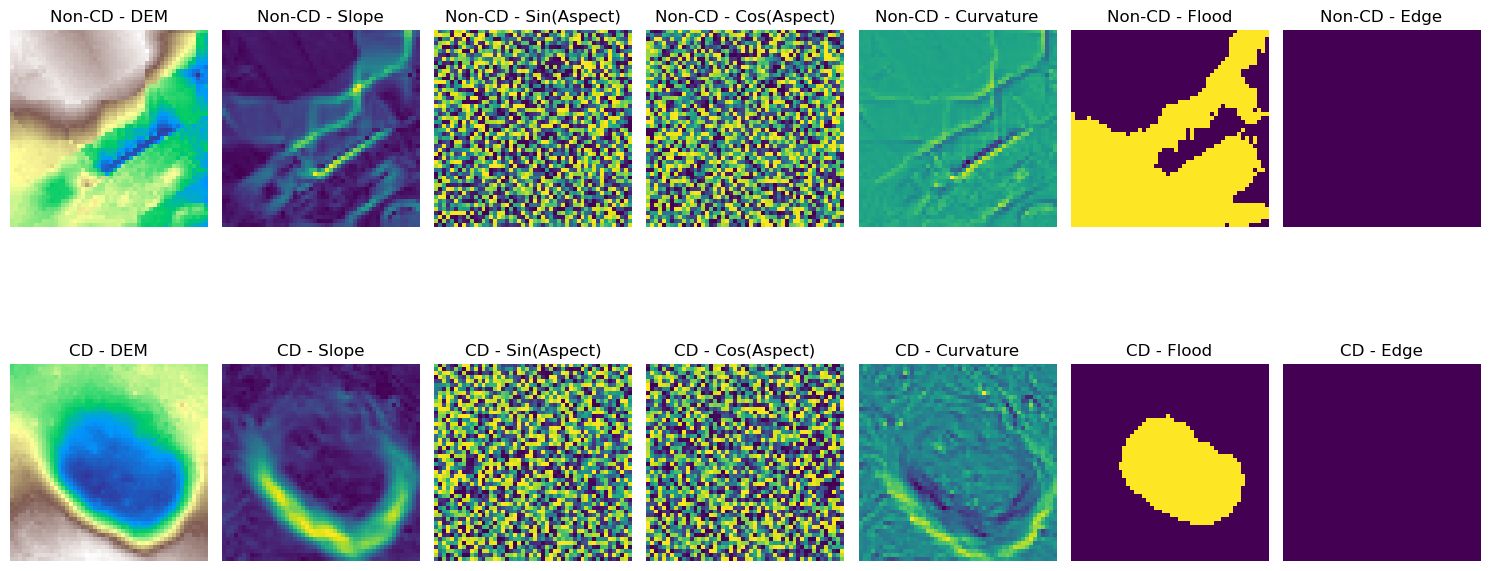

In [5]:
# === Quick visualization ===
example0 = features0_array[6]
example1 = features1_array[6] 

fig, axes = plt.subplots(2, 7, figsize=(15, 8))

feature_names = ['DEM', 'Slope', 'Sin(Aspect)', 'Cos(Aspect)', 'Curvature', 'Flood', 'Edge']

# Plot for non-CD
for i in range(7):
    axes[0, i].imshow(example0[i], cmap='terrain' if i == 0 else 'viridis')
    axes[0, i].set_title(f"Non-CD - {feature_names[i]}")
    axes[0, i].axis('off')

# Plot for CD
for i in range(7):
    axes[1, i].imshow(example1[i], cmap='terrain' if i == 0 else 'viridis')
    axes[1, i].set_title(f"CD - {feature_names[i]}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

**Part III: Detection of Local Minima for Testing**

In [ ]:
# === Detect local minima ===
# File paths
dem_path = "Data/tifs/test_DHMVIIDTMRAS1m_k32_rescaled_5m.tif"
slope_path = "Data/tifs/test_slope1m_k32_rescaled_5m.tif"
output_csv = "Data/test_local_minima.csv"

# Parameters
window_size = 5
try:
    # Load and normalize DEM
    dem_array, geotransform = load_data(dem_path)
    dem_normalized = normalize_data(dem_array)
    elevation_range = np.ptp(dem_array)

    slope_array, _ = load_data(slope_path)
    slope_normalized = normalize_data(slope_array)
    slope_range = np.ptp(slope_array)

    # Detect local minima
    start_time = time.time()
    mask = detect_local_minima(dem_normalized, slope_normalized, elevation_range, slope_range, window_size)
    depressions = extract_coordinates(mask, geotransform, window_size)
    elapsed_time = time.time() - start_time

    # Save results
    print(f"Window size: {window_size}")
    print(f"Number of depressions identified: {len(depressions)}")
    print(f"Time taken: {elapsed_time:.2f} seconds")
    save_to_csv(depressions, output_csv, ['id', 'longitude', 'latitude'])
    
except Exception as e:
    print(f"Error: {e}")